In [1]:
import scipy.spatial
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import networkx as nx
from math import sqrt, pi, isclose

from copy import copy

from matplotlib.colors import LinearSegmentedColormap

In [2]:
def ccw(A,B,C):
    Ax,Ay=A
    Bx,By=B
    Cx,Cy=C
    return (Cy-Ay) * (Bx-Ax) > (By-Ay) * (Cx-Ax)

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def edge_intersect(E,F):
    A,B = E
    C,D = F
    return intersect(A,B,C,D)

def line_intersection(E, F):
    xdiff = (E[0][0] - E[1][0], F[0][0] - F[1][0])
    ydiff = (E[0][1] - E[1][1], F[0][1] - F[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*E), det(*F))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def sign(v):
    if isclose(v,0):
        return 0
    elif v>0:
        return 1
    elif v<0:
        return -1

def point_is_LR_of_line(p, line):
    x,y=p
    A,B = line
    Ax,Ay=A
    Bx,By=B
    position = sign((Bx-Ax)*(y-Ay) - (By-Ay) * (x-Ax))
    if position is None:
        print("no side", p)
        return 0
    return position

def centroid_of_shape(S):
    length=len(S)
    if length > 0:
        mean_x=sum([x for x,y in S])/length
        mean_y=sum([y for x,y in S])/length
        if mean_x is None or mean_y is None:
            print(S, "no centroid")
        return [mean_x, mean_y]
    else:
        return None


def split_shape(V,i,line):
    # Split the voronoi region located at i by
    # cutting it with a line defined by two points
    region_point_indices = V.regions[V.point_region[i]]
    region_vertices = [V.vertices[v] for v in V.regions[V.point_region[i]]]
    s_boundaries=[(region_vertices[i-1], region_vertices[i]) for i,s in enumerate(region_vertices)]
    shape_lines_and_cuts = [(e,edge_intersect(l, line), l, line_intersection(l, line) if edge_intersect(l, line) else None) for e,l in enumerate(s_boundaries)]
    return shape_lines_and_cuts

In [3]:
def genuniquecoordinates(m,n):
    seen = set()
    while True:
        x,y = random.randint(0,m), random.randint(0,n)
        if (x,y) not in seen:
            seen.add((x,y))
            yield(x,y)        

def gen_voronoi_points(space, number, seed=None):
    
    boundary_points=[]
    c=0
    for x in np.linspace(0, space[0],3):
        c=-space[1]
        boundary_points.append(np.array([x,c]))
    c=0
    for x in np.linspace(0, space[0],3):
        c=space[1]*2
        boundary_points.append(np.array([x,c]))
    x=0
    for c in np.linspace(0, space[1],3):
        x=-space[0]
        boundary_points.append(np.array([x,c]))
    x=0
    for c in np.linspace(0, space[1],3):
        x=space[0]*2
        boundary_points.append(np.array([x,c]))

    boundary_points=np.array(boundary_points).T

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    gencoords=genuniquecoordinates(*space)
    rand_point_coords = np.array([next(gencoords) for i in range(0,number)]).T
#    unique_rand_point_coords = np.array(list(set([tuple(c) for c in rand_point_coords.T]))).T
    unique_rand_point_coords = rand_point_coords
    point_coords= np.hstack([unique_rand_point_coords, 
                             boundary_points])
    
    vor = scipy.spatial.Voronoi(point_coords.T, furthest_site=False)
    delaunay = scipy.spatial.Delaunay(point_coords.T, furthest_site=False)
    

    return len(unique_rand_point_coords.T), vor, delaunay

In [4]:
def hexfill(r):
    return 3 * r * (r+1) + 1

def get_d(N, area):
    # Using hexpacking as optimal way of squeezing N items into a circular area:
    # https://oeis.org/A003215
    # Reversing to find approximate expected distance for N items in a given area
    # Joining points closer than this expected value results in optimal balance between
    # nothing joining and everything joining
    ratio = (1/6) * (sqrt(12 * N - 3) - 3)
    R = sqrt(area/pi)
    d = (R/ratio)
    return d

In [5]:
class cell_map(object):
    def __init__(self):
        pass

    def from_voronoi(self, V, shape2d, number_of_points):
        self.original_number_of_points = number_of_points
        self.bounds = shape2d
        self.points=np.copy(V.points)[:number_of_points]
        self.vertices=np.copy(V.vertices)
        self.point_region=np.array([v for v in range(0,number_of_points)])
        self.regions=copy(V.regions)
        self.regions = [C.regions[r] for r in [r for r in V.point_region[:number_of_points]]]
        self.centroids = self.calc_centroids()

        cut_lines = [[[-self.bounds[0]*2, 0], [self.bounds[0]*2, 0]],
            [[self.bounds[0], -self.bounds[1]*2], [self.bounds[0], self.bounds[1]*2]],
            [[self.bounds[0]*2, self.bounds[1]], [-self.bounds[0]*2, self.bounds[1]]],
            [[0, self.bounds[1]*2], [0, -self.bounds[1]*2]]]
        
        for k in range(0,4):
            shape_count = len(self.regions)
            for i in range(0, shape_count):
                sc = split_shape(C,i,cut_lines[k])
                #print(sc[2])
                cut_locs = [c[0] for c in sc if c[1]]
                if len(cut_locs)>0:
                    cut_ix = len(self.vertices),len(self.vertices)+1
                    cut_vx = [c[3] for c in sc if c[1]]
                    a = C.regions[self.point_region[i]][0:cut_locs[0]] + [cut_ix[0], cut_ix[1]] + self.regions[self.point_region[i]][cut_locs[1]:]
                    b = [cut_ix[0]] + self.regions[self.point_region[i]][cut_locs[0]:cut_locs[1]] + [cut_ix[1]]
                    self.vertices=np.append(self.vertices,np.array([cut_vx[0]]), axis=0)
                    self.vertices=np.append(self.vertices,np.array([cut_vx[1]]),axis=0)
                    a_vertices = np.array([self.vertices[v] for v in a])
                    b_vertices = [self.vertices[v] for v in b]
                    a_centroid = (sum([x for x,y in a_vertices])/len(a_vertices),sum([y for x,y in a_vertices])/len(a_vertices))
                    b_centroid = (sum([x for x,y in b_vertices])/len(b_vertices),sum([y for x,y in b_vertices])/len(b_vertices))
                    if point_is_LR_of_line(a_centroid, cut_lines[k])>=0:
                        self.regions[i]=a
                        self.centroids[i]=a_centroid
                        self.regions.append(b)
                        self.centroids.append(b_centroid)
                        self.points=np.append(C.points, np.array([b_centroid]),axis=0)
                        self.point_region=np.append(C.point_region,shape_count)
                        shape_count=shape_count+1
                    else:
                        self.regions[i]=b
                        self.centroids[i]=b_centroid
                        self.regions.append(a)
                        self.centroids.append(a_centroid)
                        self.points=np.append(C.points, np.array([a_centroid]),axis=0)
                        self.point_region=np.append(C.point_region,shape_count)
                        shape_count=shape_count+1

        self.world_cell_assignment = {e:True if e<self.original_number_of_points else False for e,r in enumerate(self.regions)}
        self.world_cell_borders = self.regions[0:self.original_number_of_points]
        self.non_world_cell_borders = self.regions[self.original_number_of_points:]
        self.world_cell_centroids = self.centroids[0:self.original_number_of_points]
        self.non_world_cell_centroids = self.centroids[self.original_number_of_points:]
        self.world_points = self.points[0:self.original_number_of_points]
        self.non_world_points = self.points[self.original_number_of_points:]
        self.world_point_region = self.point_region[0:self.original_number_of_points]
        self.world_point_region = self.point_region[self.original_number_of_points:]
        
        return self

    def calc_centroids(self):
        centroids=[]
        for i in range(0,len(self.points)):
            region_vertices = [self.vertices[v] for v in self.regions[self.point_region[i]]]
            length=len(region_vertices)
            centroid=(sum([x for x,y in region_vertices])/length,sum([y for x,y in region_vertices])/length)
            centroids.append(centroid)
        return centroids

    def calc_linkages(self, distance=None, adjust=0):
        
        pdist=scipy.spatial.distance.cdist(self.points[0:self.original_number_of_points], self.points[0:self.original_number_of_points])
        
        if distance is None:
            distance = get_d(len(self.points), self.bounds[0] * self.bounds[1])

        distance = distance + adjust
        
        links=np.array(np.where((pdist>0)&(pdist<distance))).T
        dg=nx.Graph()
        for cell in range(len(self.points)):
            dg.add_node(cell)
        for f,t in links:
            if f<t:
                dg.add_edge(int(f),int(t))

        self.linkage_graph=dg
        return dg

    def calc_cell_linkages(self):
        border_facets=dict()
        rg = nx.Graph()
        for i,r in enumerate(C.regions):
            if self.world_cell_assignment.get(i)==True:
                rg.add_node(i)
            else:
                #print(i)
                pass
            for j in range(len(r)):
                border=tuple(sorted((r[j], r[j-1]))) # normalise borders to singluar form
                if border in border_facets.keys(): # seen this one before
                    if not any([b==-1 for b in border]):
                        border_facets[border].append(i)
                else:
                    if not any([b==-1 for b in border]):
                        border_facets[border]=[i]
                    else:
                        print(border)

        for k,v in border_facets.items():
            if len(v)>1:
                rg.add_edge(int(v[0]), int(v[1]))
            else:
                print("bad facet")
                print(k, v)
        self.neighbor_graph=rg
        return rg

    def calc_cell_linkages_x(self):
        border_facets=dict()
        live_regions = C.regions
        
        for i,r in enumerate(live_regions):
            for j in range(len(r)):
                border = tuple(sorted((r[j], r[j-1])))
                                   
                if border in border_facets.keys() :
                    if not any([b==-1 for b in border]):
                        border_facets[border].append(i)
                        #print(i, border)
                else:
                    border_facets[border]=[i]
        # Create graph containing all cells connected by borders
        rg = nx.Graph()
        for k,v in border_facets.items():
            if len(v)>1:
                rg.add_edge(int(v[0]), int(v[1]))
            else:
                print("bad facet")
                print(k, v)
        self.neighbor_graph=rg
        return rg

    def calc_linked_regions(self):
        all_connected = {s for r in nx.connected_components(self.neighbor_graph) for s in r}
        singletons = [set([s]) for s in set(self.neighbor_graph.nodes()) if s not in all_connected]
        self.region_sets = list(nx.connected_components(self.linkage_graph)) + singletons


        region_graph=nx.Graph()
        for e,r in enumerate(self.region_sets):
            neighbourset=set()
            for n in r:
                if n in self.neighbor_graph.nodes():
                    neighbourset.update(self.neighbor_graph.neighbors(n))
            for f,r_two in enumerate(self.region_sets):
                if e!=f:
                    if len(neighbourset.intersection(r_two))>0:
                        region_graph.add_edge(e,f)

        self.region_graph = region_graph

    def bicolour_regions(self):
        processed=set()
        assignments=dict()
        regions_by_size=sorted([(k,v) for k,v in self.region_graph.degree()], key=lambda x : x[1], reverse=True)
#        r = regions_by_size[0][0]
        
        for r,s in regions_by_size:
            if r not in processed:
                processed.add(r)
                assignments[r]=0
                for a in self.region_graph.neighbors(r):
                    if a not in processed:
                        processed.add(a)
                        assignments[a]=1
        return assignments

    def calc_world_rivers(self):
        land_regions = [(e,land_region) for e,land_region in enumerate(self.region_sets) if self.region_bicolour_assignments[e]==1]
        for region, content in land_regions:
            print (region, content, [list(self.neighbor_graph.neighbors(cell))for cell in content])
            print ()


    def calc_world_values(self, adjust=0):
        self.calc_cell_linkages()
        self.calc_linkages(adjust=adjust)
        self.calc_linked_regions()
        self.region_bicolour_assignments=self.bicolour_regions()
        self.region_lookup = {c:e for e,v in enumerate(self.region_sets) for c in v}  # dict mapping from cell to region
        self.cell_region_colour_lookup = {k:self.region_bicolour_assignments.get(v) for k,v in self.region_lookup.items()}
        
                

In [6]:
space_dims = (900,900)

number_of_points = 90

number_of_points,V,D = gen_voronoi_points(space_dims, number_of_points, seed=1000) 
number_of_points

90

In [7]:
C=cell_map()
C.from_voronoi(V,space_dims, number_of_points)
C.calc_world_values(adjust=0.0)

bad facet
(51, 250) [2]
bad facet
(21, 251) [2]
bad facet
(35, 190) [3]
bad facet
(61, 191) [3]
bad facet
(58, 210) [12]
bad facet
(55, 211) [12]
bad facet
(48, 192) [13]
bad facet
(26, 193) [13]
bad facet
(63, 194) [15]
bad facet
(61, 195) [15]
bad facet
(29, 252) [19]
bad facet
(28, 253) [19]
bad facet
(141, 212) [20]
bad facet
(58, 213) [20]
bad facet
(171, 234) [22]
bad facet
(215, 235) [22]
bad facet
(168, 215) [22]
bad facet
(21, 254) [28]
bad facet
(21, 255) [28]
bad facet
(37, 196) [29]
bad facet
(196, 216) [29]
bad facet
(37, 217) [29]
bad facet
(114, 236) [30]
bad facet
(171, 237) [30]
bad facet
(115, 238) [39]
bad facet
(114, 239) [39]
bad facet
(198, 256) [45]
bad facet
(45, 198) [45]
bad facet
(45, 257) [45]
bad facet
(109, 258) [48]
bad facet
(40, 259) [48]
bad facet
(188, 240) [49]
bad facet
(96, 241) [49]
bad facet
(37, 200) [50]
bad facet
(103, 201) [50]
bad facet
(64, 220) [51]
bad facet
(55, 221) [51]
bad facet
(149, 260) [53]
bad facet
(29, 261) [53]
bad facet
(64, 

In [8]:
C.neighbor_graph.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 120, 90, 100, 91, 92, 121, 101, 112, 122, 103, 113, 114, 123, 124, 115, 95, 105, 125, 106, 107, 116, 126, 118, 96, 127, 128, 97, 108, 129, 98, 109, 93, 110, 94, 130, 131, 99, 102, 119, 104, 111, 117, 132))

(-5.0, 905.0)

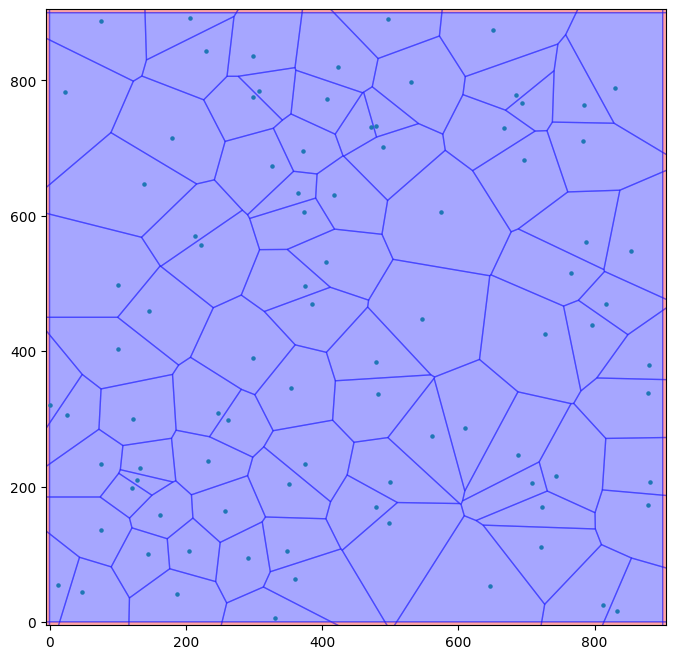

In [9]:
fig=plt.figure(figsize=(8,8))
ax = plt.gca()

for i in range(0,number_of_points):

    vi = C.regions[C.point_region[i]]
    vertices=np.array([C.vertices[v] for v in vi])
    ax.add_patch(mpatches.Polygon(np.array(vertices), edgecolor='blue', facecolor = 'blue', alpha=0.35))

for i in range(number_of_points,len(C.regions)):
    vi = C.regions[i]
    vertices=np.array([C.vertices[v] for v in vi])
    ax.add_patch(mpatches.Polygon(np.array(vertices), edgecolor='blue', facecolor = 'red', alpha=0.35))
    
ax.scatter(*C.points[0:number_of_points].T, s=5)
plt.xlim(-5,space_dims[0]+5)
plt.ylim(-5,space_dims[1]+5)

In [10]:
clist=['forestgreen','cornflowerblue', '2','3','4','5','black']

In [11]:
shapes=[]
for i in range(0,len(C.regions)):

    vi = C.regions[C.point_region[i]]
    shapes.append(np.array([C.vertices[v] for v in vi]))


In [12]:
 C.neighbor_graph.nodes() 

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 120, 90, 100, 91, 92, 121, 101, 112, 122, 103, 113, 114, 123, 124, 115, 95, 105, 125, 106, 107, 116, 126, 118, 96, 127, 128, 97, 108, 129, 98, 109, 93, 110, 94, 130, 131, 99, 102, 119, 104, 111, 117, 132))

In [13]:
hdegree_d=dict(C.linkage_graph.degree)

cell_dict = dict()
for cell in C.neighbor_graph.nodes() :
    if cell < 999999:#number_of_points:
        cell_dict[cell]={}
        cell_dict[cell]["region"]=C.region_lookup[cell]
        cell_dict[cell]["bicolour"]=C.cell_region_colour_lookup[C.region_lookup[cell]]
        colour_dir = 1 if C.cell_region_colour_lookup[cell] == 0 else -1
        cell_dict[cell]["height"]=(hdegree_d.get(cell,0)*colour_dir)-1
        cell_dict[cell]["shape"]=np.array(shapes[cell] )
        cell_dict[cell]["neighbors"]=list(C.neighbor_graph.neighbors(cell))
        cell_dict[cell]["link_neighbors"]=list(C.linkage_graph.neighbors(cell))
        cell_dict[cell]['v_point']=C.points[cell]
        cell_dict[cell]['vertex_indices']=C.regions[C.point_region[cell]]
        cell_dict[cell]['vertex_pos']=[C.vertices[v] for v in C.regions[C.point_region[cell]]]


In [14]:
heights = [v['height'] for v in cell_dict.values() ]
sea_level = 0
land_heightnorm=plt.Normalize(sea_level, max(heights))
sea_heightnorm=plt.Normalize(min(heights), sea_level)


In [15]:


#land_colors = [(0.6, 1, 0.6), (0.3, 0.8, 0.3), (0.3, 0.3, 0.3)] 
land_colors = [(0.6, 1, 0.6), (0.2, 0.2, 0.2)] 
land_colors_cmap = LinearSegmentedColormap.from_list("land_colors", land_colors, N=16)

#sea_colors = [(0.4, 0.5, 0.9), (0.5, 0.5, 1.0), (0.6, 0.6, 1.0)] 
sea_colors = [(0.1, 0.1, 0.5), (0.6, 0.6, 1.0)] 
sea_colors_cmap = LinearSegmentedColormap.from_list("sea_colors", sea_colors, N=16)



/tmp/ipykernel_12031/2080763747.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch=mpatches.Polygon(data['shape'], edgecolor='black', color=cvalue, alpha=0.8)


(-5.0, 905.0)

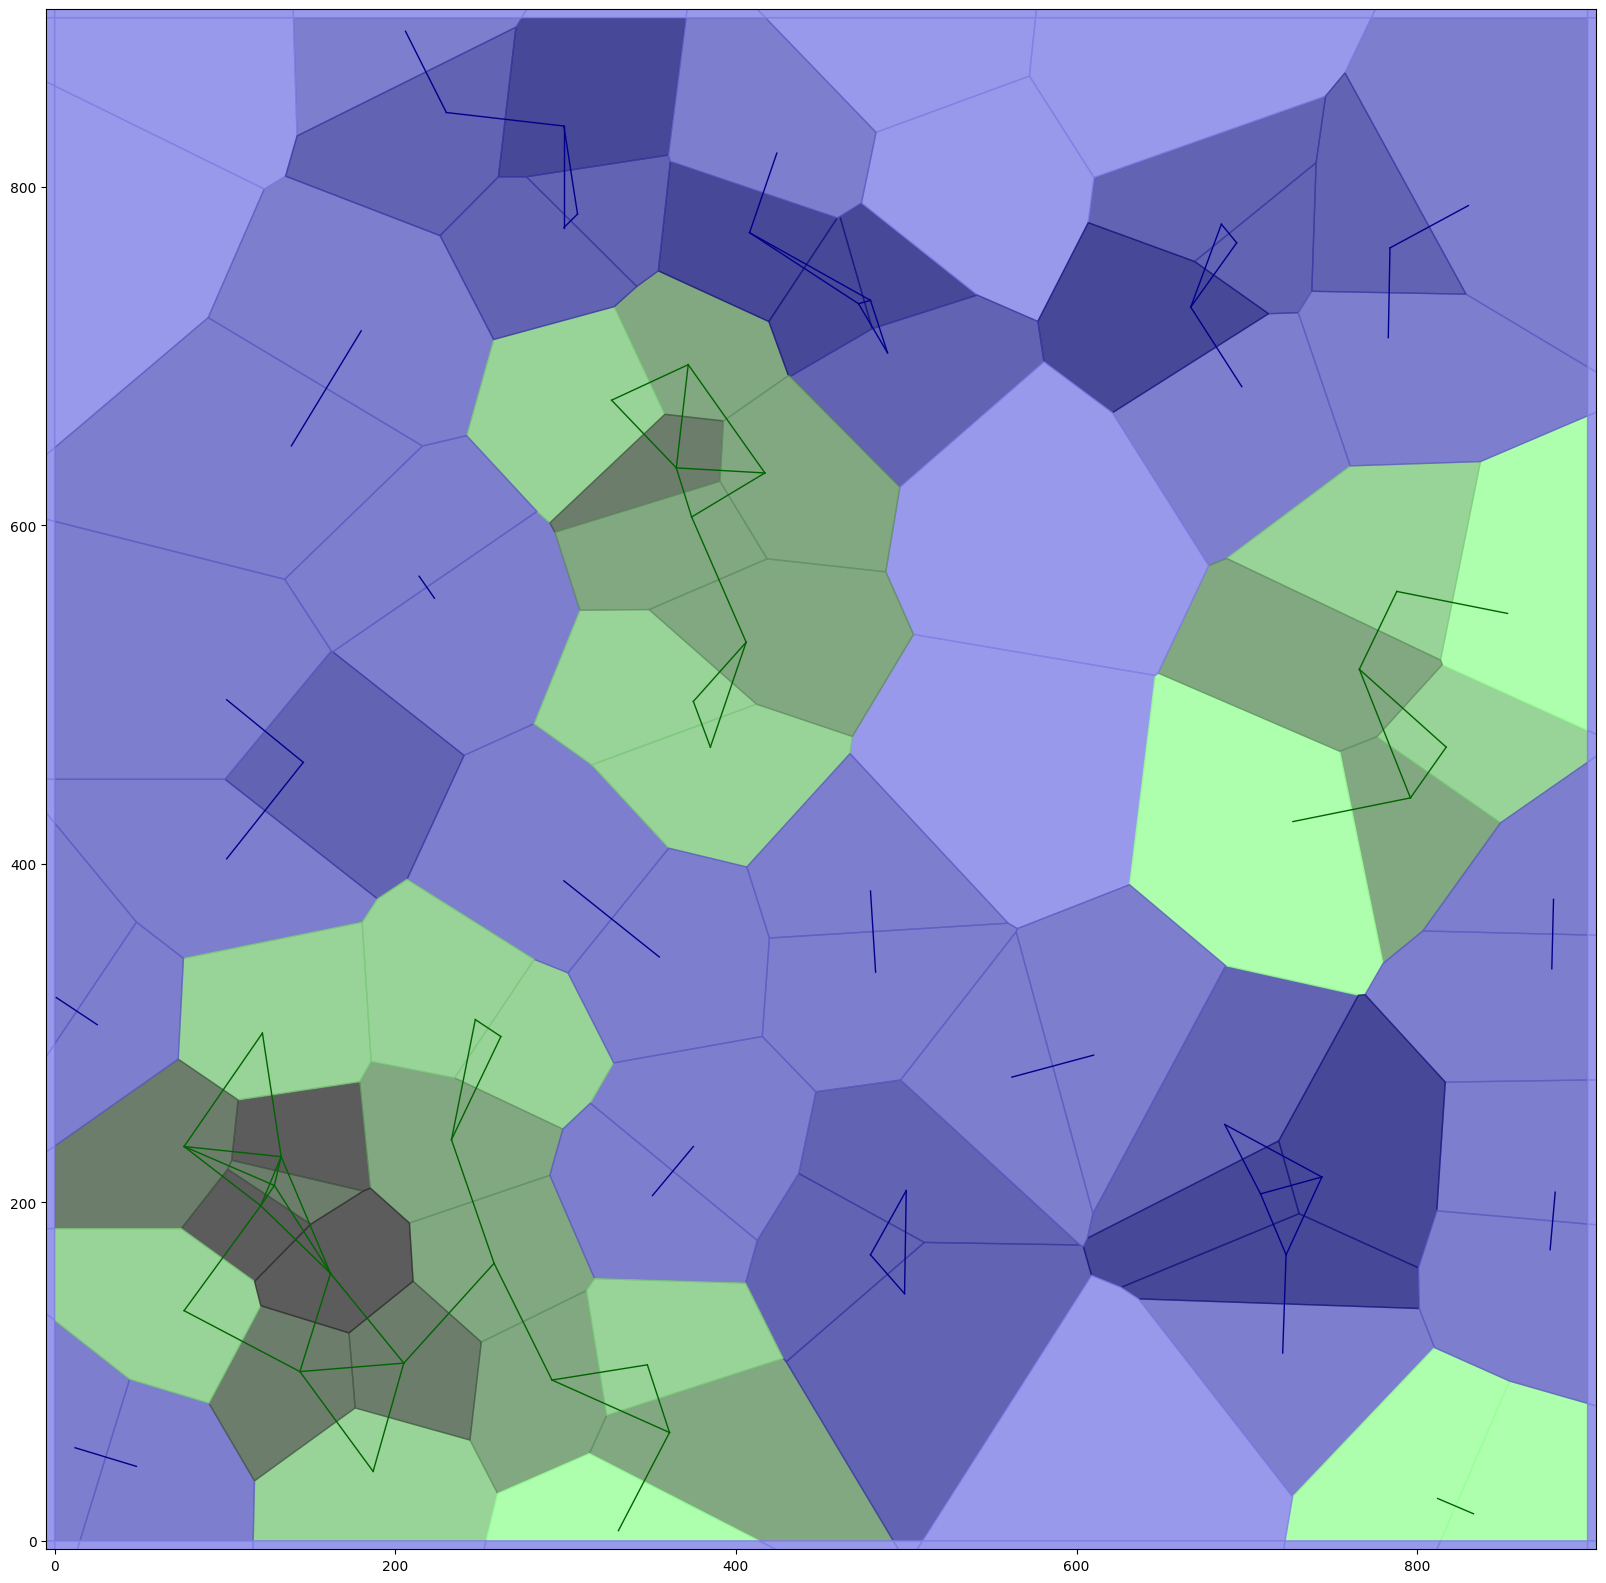

In [16]:
cmap = plt.get_cmap('gist_rainbow')
cmap = plt.get_cmap('summer')
scmap = plt.get_cmap('cool')
#cmap = plt.get_cmap('gist_ncar')
#cmap = plt.get_cmap('nipy_spectral')
#cmap = plt.get_cmap('jet')

fig=plt.figure(figsize=(20,20))
ax = plt.gca()

for cell, data in cell_dict.items():
    if data['height']>=sea_level:
        cvalue = land_colors_cmap(land_heightnorm(data['height']))
    else:
        cvalue = sea_colors_cmap(sea_heightnorm(data['height']))
    patch=mpatches.Polygon(data['shape'], edgecolor='black', color=cvalue, alpha=0.8)
    ax.add_patch(patch)


for f,t in C.linkage_graph.edges():
    if C.cell_region_colour_lookup.get(f,6)==0:
        x1y1=C.points[f][0], C.points[f][1]
        x2y2=C.points[t][0], C.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkgreen',linewidth=1)
    elif C.cell_region_colour_lookup.get(f,6)==1:
        x1y1=C.points[f][0], C.points[f][1]
        x2y2=C.points[t][0], C.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkblue',linewidth=1)

plt.xlim(-5,space_dims[0]+5)
plt.ylim(-5,space_dims[1]+5)

# Old Todo list (updated with done-tasks struck-through)
1) <strike>Cut a shape, or series of shapes, using a line, such that the shapes are bounded by the applied cut-line. </strike>
2) Sub-divide a single voronoi cell (defined by a series of line boundaries) into a shaped voronoi collection (by the application of a random set of points)
3) Determine the rules to generate rivers (adjacent region tiles that don't share a backbone-link)
4) <strike>Using degree to determine height - where node degree (of backbones) is on a land region, then it's positive, when it's in an ocean region, then it's negative. Experiment with rising/falling sea-levels.</strike>
5) Optional demotion of land regions. i.e. given some integer quota, cycle over the available land-masses, and randomly demote them to being ocean regions. Motivation is to enable tuning of the finished map from archipelago towards continental qualities.
6) Optional region joining - again with a motivation to push the continental quality of a generated map, it might be beneficial to join some adjacent regions together to form a larger set of land-masses. This might take the form of choosing a starting land-mass, and connecting it to surrounding regions.
7) <strike>After determining height using method in (4) experiment with raising/lowering sea-levels to explore effects</strike>
8) Applying different base temperatures based on latitude, with equatorial, tropical, temperate and polar designations. i.e. Apply Köppen climate classification to cells based on latitude:
   * Tropical climates (A)
   * Dry climates (B)
   * Temperate climates (C) 
   * Continental climates (D)
   * Polar climates (E)
10) Generating tradewinds/oceanic currents/vortices, finding cycles that apply in ocean regions, and using those to apply costal transverse flows. These in turn might adjust local temperature/climates experienced at different cells.

# New Todo List
1. Construct world hosting object, containing cells, borders, regions, links, etc for world-level procedures
2. Within that world-hosting object, implement river generation routine/rules
3. Within world-hosting object consider ocean currents using gyre/vortex procedural
4. Consider application and effect of Koppen climate classification based on latitude. For continuing reference, these are:
   * (A) Tropical Climates
   * (B) Dry climates
   * (C) Temperate Climates
   * (D) Continental Climates
   * (E) Polar Climates